# Sanity Checks! 
I will use this notebook to verify certain results about the ABS spectra for finite l.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
import scipy.special
import scipy.integrate

In [7]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [8]:
# create the Hamiltonian matrix

def calc_subband_hamiltonian(params):
    '''
    Returns the Hamiltonian in the real space basis.
    params is a dict with the following information:
        N_z : number of points along z
        t_z : h^2/(2 m a^2), where a is lattice spacing
        t_phi : h^2/(2 m R^2), where a is lattice spacing
        mu : chemical potential
        flux : axial flux in h/e units
        Delta : order parameter
        l : subband index
    '''
    N_z = params['N_z']
    t_z = params['t_z']
    t_phi = params['t_phi']
    mu = params['mu']
    flux = params['flux']
    Delta = params['Delta']
    l = params['l']
  
    mu_e = mu - t_phi*(l - flux)**2
    mu_h = mu - t_phi*(l + flux)**2
    
    def calc_matrix_element(z1,z2):
        '''
        Returns the matrix element between two real space points x and y
        '''
        # onsite element
        if z1 == z2:
            diag_ele = 2*t_z 
            return np.array([[diag_ele - mu_e,Delta],[np.conj(Delta),-diag_ele+mu_h ]])
        # z hopping
        elif abs(z1-z2) == 1:
            return np.array([[-t_z,0],[0,t_z]])
        else:
            return np.array([[0,0],[0,0]])
    
    H_list = [calc_matrix_element(x,y) for x in range(N_z) for y in range(N_z)]
    H = np.array(H_list).reshape((N_z,N_z,2,2))
    
    # magic to flatten the Hamiltonian
    # Are you wathing closely?
    H = np.array([H[x,:,y,:].flatten() for x in range(H.shape[0]) for y in range(H.shape[2])])\
    .flatten().reshape(2*N_z,2*N_z)
    
    return H

In [9]:
# surface Green's funciton routines
# ordinary iteration schemes will be used

def calc_surface_g(E,alpha,beta,eta,eps = 1e-8,max_iter=100000,kappa=0.5):
    '''
    Return the surface Green's function at energy E 
   
    eta is used to calculated the Green's function
    eps controls the accuracy
    
    Returns the surface Green's function as a solution of the recursive relation 
    g = ((E + 1j*eta) - alpha - beta'*g*beta)^-1
    '''
    # conv here to avoid problems later
    E = np.array(E)
    
    
    def func_g(g,E,alpha,beta,eta):
        return np.linalg.inv((E + 1j*eta).reshape(-1,1,1)*np.eye(alpha.shape[0])- alpha - beta @ g @ np.conj(beta).T)
   
    g0 = np.zeros((len(E),alpha.shape[0],alpha.shape[1]))
    g = np.zeros((len(E),alpha.shape[0],alpha.shape[1]))
    
    err_vec = []
    for i in range(max_iter):
        g = func_g(g,E,alpha,beta,eta)
        g = ((1-kappa)*g + kappa*g0)
        err = np.linalg.norm(g - g0)/len(E)
        err_vec.append(err)
        g0 = np.copy(g)
        if err < eps:
            break
    return g

In [14]:
def calc_sns_negf(E,params):
    '''
    Returns the G,A,Sigma matrices for SNS device. The chemical potential will be assumed to same everywhere and
    no bias is present across the device.
    params dict takes in these parameters:
        N_z : number of points along z in the normal region
        t_z : h^2/(2 m a^2), where a is lattice spacing
        t_phi : h^2/(2 m R^2), where a is lattice spacing
        mu : chemical potential
        Delta_1 : superconducting parameter 1
        Delta_2 : superconducting parameter 2
        eta : imaginary 0+ added for convergence
        flux : axial flux in h/e units
        l : subband index
    '''
    N_z = params['N_z']
    t_z = params['t_z']
    t_phi = params['t_phi']
    Delta_1 = params['Delta_1']
    Delta_2 = params['Delta_2']
    mu = params['mu']
    eta = params['eta']
    flux = params['flux']
    kT = params['kT']
    l = params['l']
  
    mu_e = mu - t_phi*(l - flux)**2
    mu_h = mu - t_phi*(l + flux)**2
    
    # create alpha/beta hamiltonians for S regions
    # calc surface Green's function
   
    params_S1 = {'t_z' : t_z,'t_phi' : t_phi,'N_z' : 2, "Delta" : Delta_1, "mu" : mu,"flux" : flux, "l" : 0}
    H_S1 = calc_subband_hamiltonian(params_S1)   
    surface_dof = 2
    alpha_1 = H_S1[:surface_dof,:surface_dof]
    beta_1 = H_S1[:surface_dof,surface_dof:2*surface_dof]
    g_1 = calc_surface_g(E,alpha_1,beta_1,eta)
    
    params_S2 = {'t_z' : t_z,'t_phi' : t_phi,'N_z' : 2, "Delta" : Delta_2, "mu" : mu,"flux" : flux, "l" : 0}
    H_S2 = calc_subband_hamiltonian(params_S2)   
    surface_dof = 2
    alpha_2 = H_S2[:surface_dof,:surface_dof]
    beta_2 = H_S2[:surface_dof,surface_dof:2*surface_dof]
    g_2 = calc_surface_g(E,alpha_2,beta_2,eta)
    
    I = np.zeros(len(E))
    total_dos = np.zeros(len(E))
    for l_subband in range(-l,l+1,1):
        # create Hamiltonian for N region
        params_N = {'t_z' : t_z,'t_phi' : t_phi,'N_z' : N_z, "Delta" : 0, "mu" : mu,"flux" : flux, "l" : l_subband}
        H_mat = calc_subband_hamiltonian(params_N)

        #number of dof in a layer
        N_dof_lat = 2
        # the hopping element between layers
        beta_layer = H_mat[:N_dof_lat,N_dof_lat:2*N_dof_lat]

        # the only non-zero elements in sigma
        sigma_mini_1 = np.conj(np.transpose(beta_layer[np.newaxis,:,:],(0,2,1)))@g_1@beta_layer
        sigma_mini_2 = np.conj(np.transpose(beta_layer[np.newaxis,:,:],(0,2,1)))@g_2@beta_layer

        sigma_1 = np.zeros((len(E),H_mat.shape[0],H_mat.shape[1]),dtype=np.complex64)
        sigma_1[:,:N_dof_lat,:N_dof_lat] = sigma_mini_1
        gamma_1 = 1j*(sigma_1 - np.transpose(np.conj(sigma_1),(0,2,1)))

        sigma_2 = np.zeros((len(E),H_mat.shape[0],H_mat.shape[1]),dtype=np.complex64)
        sigma_2[:,-N_dof_lat:,-N_dof_lat:] = sigma_mini_2
        gamma_2 = 1j*(sigma_2 - np.transpose(np.conj(sigma_2),(0,2,1)))

        # NEGF matrices
        G = np.linalg.inv((E + 1j*eta).reshape(-1,1,1)*np.eye(H_mat.shape[0]) - H_mat - sigma_1 - sigma_2)

        A = 1j*(G - np.transpose(np.conj(G),(0,2,1))) 
        dos = np.real(np.trace(A,axis1=-2,axis2=-1))
        total_dos += dos

        def fermi(E,kT):
            return scipy.special.expit(-E/kT)

        def generate_fermi_matrix(E,mu_e,mu_h,mu,kT):
            return np.array([[[fermi(ele - mu_e+mu,kT),0],[0,fermi(ele + mu_h-mu,kT)]] for ele in E])

        F1 = np.kron(np.eye(N_z),generate_fermi_matrix(E,mu,mu,mu,kT))
        F2 = np.kron(np.eye(N_z),generate_fermi_matrix(E,mu,mu,mu,kT))
        sigma_in = np.matmul(gamma_1,F1) + np.matmul(gamma_2,F2)

        G_n = np.matmul(G,np.matmul(sigma_in,np.transpose(np.conj(G),(0,2,1))))

        #I_mat = 1j*(np.matmul(G_n[:N_dof_lat,N_dof_lat:2*N_dof_lat],beta_layer) \
        #         - np.matmul(G_n[N_dof_lat:2*N_dof_lat,:N_dof_lat],beta_layer))
        I_mat = 1j*(np.matmul(H_mat,G_n) - np.matmul(G_n,H_mat))
        # current = electron current - hole current
        I += np.real(np.trace(I_mat[:,0:2:2,0:2:2]-I_mat[:,1:2:2,1:2:2],axis1=-1,axis2=-2))

    return dos,I

In [17]:
def integrate_current(E_vec,I_vec):
    return scipy.integrate.simps(I_vec,E_vec) 

def calc_I_phi(params,E_vec,phi_vec):
    I_phi = []
    for phi in phi_vec:
        params['Delta_2'] = params['Delta_1']*np.exp(1j*phi)
        dos,I = calc_sns_negf(E_vec,params)
        I_phi.append(integrate_current(E_vec,I))
    I_phi = np.array(I_phi)
    return I_phi

In [18]:
def calc_critical_current(phi_vec,I_phi):
    '''
    Returns the critical current value given I(phi) and the critical phase
    '''
    arg_max = np.argmax(I_phi,axis=1)
    I_c = I_phi[arg_max]
    return I_c,phi_vec[arg_max]

# Experiments

## Shift of DOS with flux 
The quantization condition for finite l appears as if the phase difference between the two superconductors has shifted by a finite amount.

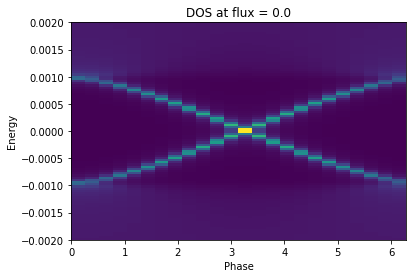

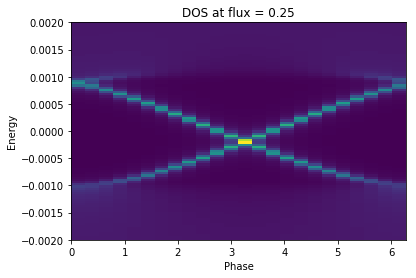

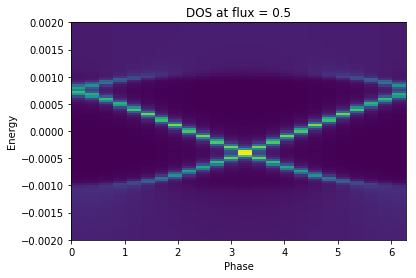

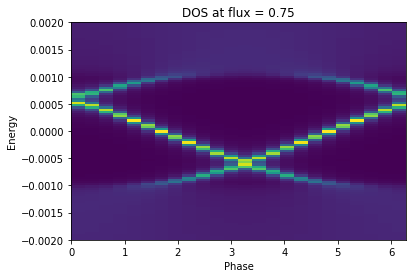

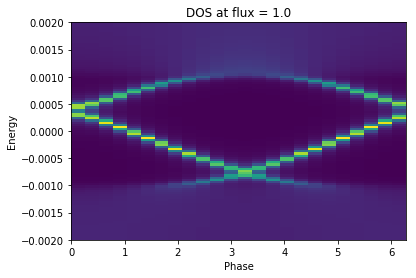

In [19]:
# sns calculation
params = {
    "N_z" : 10,
    "t_z" : 25e-3,
    "t_phi" : 2e-3,
    "Delta_1" : 1e-3,
    "Delta_2" : 1e-3,
    "mu" : 20e-3,
    "kT" : 1e-5
}
params["l"] = 1

E_vec = np.linspace(-2e-3,2e-3,100)
params['eta'] = np.abs(E_vec[1] - E_vec[0])

flux_vec = np.linspace(0,1,5,endpoint=True)
for i,flux in enumerate(flux_vec):
    params["flux"] = flux
    dos_arr = []
    phi_vec = np.linspace(0,2*np.pi,25)
    for phi in phi_vec:
        params['Delta_2'] = params['Delta_1']*np.exp(1j*phi)
        dos,I = calc_sns_negf(E_vec,params)
        dos_arr.append(dos)

    dos_arr = np.array(dos_arr).T
    XX,YY = np.meshgrid(phi_vec,E_vec)
    plt.figure(i)
    plt.pcolor(XX,YY,dos_arr)
    plt.xlabel("Phase")
    plt.ylabel("Energy")
    plt.title("DOS at flux = " + str(flux))

# Effect of Length
I want to understand what decides the length in my system.

- Hypothesis 1: Number of points - I have reservations since the spectrum is unchanged, only sampled more

- Hypothesis 2: t_z parameter with fixed number of points

In [ ]:
# sns calculation
params = {
    "N_z" : 63,
    "t_z" : 25e-3,
    "t_phi" : 2e-3,
    "Delta_1" : 1e-3,
    "Delta_2" : 1e-3,
    "mu" : 20e-3,
    "kT" : 1e-5
}
params["l"] = 0

E_vec = np.linspace(-2e-3,2e-3,100)
params['eta'] = np.abs(E_vec[1] - E_vec[0])

params["flux"] = 0.0
dos_arr = []
phi_vec = np.linspace(0,2*np.pi,50)
for phi in phi_vec:
    params['Delta_2'] = params['Delta_1']*np.exp(1j*phi)
    dos,I = calc_sns_negf(E_vec,params)
    dos_arr.append(dos)

dos_arr = np.array(dos_arr).T
XX,YY = np.meshgrid(phi_vec,E_vec)
plt.figure(i)
plt.pcolor(XX,YY,dos_arr)
plt.xlabel("Phase")
plt.ylabel("Energy")
plt.title("DOS at flux = " + str(params['flux']))


In [ ]:
print("length",params['N_z']*np.sqrt(1.7/params['t_z']))
print("radius",np.sqrt(1.7/params['t_phi']))

**Conlusion:** Changing t_z and N_z both affects the length in the logical way. Combinations of N_z and t_z which give the same length give the same dos.

In [ ]:
# I want to see the effect of chaning length at constant but finite flux 
# sns calculation
params = {
    "N_z" : 20,
    "t_z" : 25e-3,
    "t_phi" : 2e-3,
    "Delta_1" : 1e-3,
    "Delta_2" : 1e-3,
    "mu" : 20e-3,
    "kT" : 1e-5
}
params["l"] = 1

E_vec = np.linspace(-2e-3,2e-3,100)
params['eta'] = np.abs(E_vec[1] - E_vec[0])

params["flux"] = 0.1
N_z_vec = np.linspace(10,60,5,endpoint=True)
for i,N_z in enumerate(N_z_vec):
    params['N_z'] = int(N_z)
    dos_arr = []
    phi_vec = np.linspace(0,2*np.pi,50)
    for phi in phi_vec:
        params['Delta_2'] = params['Delta_1']*np.exp(1j*phi)
        dos,I = calc_sns_negf(E_vec,params)
        dos_arr.append(dos)

    dos_arr = np.array(dos_arr).T
    XX,YY = np.meshgrid(phi_vec,E_vec)
    plt.figure(i)
    plt.pcolor(XX,YY,dos_arr)
    plt.xlabel("Phase")
    plt.ylabel("Energy")
    plt.title("DOS at N_z = " + str(params['N_z']))
    print("length",params['N_z']*np.sqrt(1.7/params['t_z']))

## Integration Scheme Check
I want to determine if it computationally efficient to use a equally spaced grid for integrating I(E)

In [ ]:
# sns calculation
params = {
    "N_z" : 4,
    "t_z" : 25e-3,
    "t_phi" : 2e-3,
    "Delta_1" : 1e-3,
    "Delta_2" : 1e-3,
    "mu" : 40e-3,
    "kT" : 1e-5,
    "flux" : 0.0
}
params["l"] = 1

E_vec = np.linspace(-2e-3,2e-3,100)
params['eta'] = np.abs(E_vec[1] - E_vec[0])

phi = np.pi/4
params['Delta_2'] = params['Delta_1']*np.exp(1j*phi)
%lprun -f calc_sns_negf I = calc_sns_negf(E_vec,params)

In [ ]:
def I_E_wrapper(E,params=params):
    dos,I = calc_sns_negf(np.array([E]),params) 
    return I[0]
print(I_E_wrapper(0.5e-3,params))

In [ ]:
# using quad
%lprun -f calc_sns_negf I_quad = scipy.integrate.quad(I_E_wrapper,-2e-3,2e-3,epsrel=1e-2)[0]

In [ ]:
# using simpson rule on a equally spaced grid
E_vec = np.linspace(-2e-3,2e-3,100)
dos,I = calc_sns_negf(E_vec,params)
I_simps = integrate_current(E_vec,I)

In [ ]:
rel_error = abs((I_quad - I_simps)/I_simps)
print(rel_error)

In [ ]:
N_points = np.logspace(1,3,10)
rel_error_vec = []
for N in N_points:
    E_vec = np.linspace(-2e-3,2e-3,int(N))
    dos,I = calc_sns_negf(E_vec,params)
    I_simps = integrate_current(E_vec,I)
    
    rel_error = abs((I_quad - I_simps)/I_quad)
    rel_error_vec.append(rel_error)

In [ ]:
plt.loglog(N_points,rel_error_vec)
plt.xlabel("Number of points in energy grid")
plt.ylabel("rel error")

# Continuimn Current and Bound State Current
I want to study the two components of current and their relative contribution to the current phase relationship.

In [25]:
# with simpson integration`
params = {
    "N_z" : 4,
    "t_z" : 25e-3,
    "t_phi" : 2e-3,
    "Delta_1" : 1e-3,
    "Delta_2" : 1e-3,
    "mu" : 40e-3,
    "kT" : 1e-5,
    "flux" : 0.0
}
params["l"] = 1

E_bound_vec = np.linspace(-1.1e-3,1.1e-3,1000)
E_cont_vec_1 = np.linspace(-10e-3,-1.1e-3,1000)
E_cont_vec_2 = np.linspace(1.1e-3,10e-3,1000)
params['eta'] = np.abs(E_bound_vec[1] - E_bound_vec[0])

phi_vec = np.linspace(0,2*np.pi,200) 

I_bound = calc_I_phi(params,E_bound_vec,phi_vec)
I_cont = calc_I_phi(params,E_cont_vec_1,phi_vec) + calc_I_phi(params,E_cont_vec_2,phi_vec)

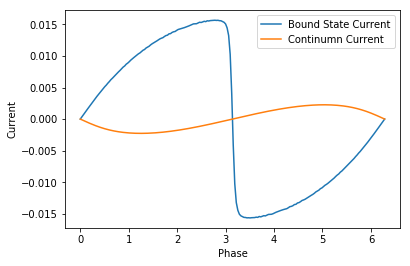

In [26]:
plt.plot(phi_vec,I_bound,label="Bound State Current")
plt.plot(phi_vec,I_cont,label="Continumn Current")
plt.xlabel("Phase")
plt.ylabel("Current")
plt.legend()

## Effect of length

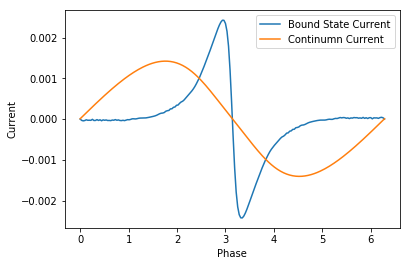

In [29]:
N_z_vec = [64]
for i,N_z in enumerate(N_z_vec):
    params['N_z'] = N_z
    
    I_bound = calc_I_phi(params,E_bound_vec,phi_vec)
    I_cont = calc_I_phi(params,E_cont_vec_1,phi_vec) + calc_I_phi(params,E_cont_vec_2,phi_vec)
    
    plt.figure(i)
    plt.plot(phi_vec,I_bound,label="Bound State Current")
    plt.plot(phi_vec,I_cont,label="Continumn Current")
    plt.xlabel("Phase")
    plt.ylabel("Current")
    plt.legend()
    